<a href="https://colab.research.google.com/github/hakuban-create/Chest_xray_Project_4/blob/mmacinnis/xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)


In [2]:
# Filepaths, numpy, and Tensorflow
import os
import cv2
from google.colab import drive
import numpy as np
import tensorflow as tf

In [3]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

In [30]:
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from io import BytesIO
from tensorflow.keras.preprocessing import image

In [5]:
drive.mount('/content/drive')

data_directory_path = os.path.join("/content/drive/MyDrive/chest_xray")
train_directory_path = os.path.join(data_directory_path, "train")
train_normal_path = os.path.join(train_directory_path, "NORMAL")
train_pneumonia_path = os.path.join(train_directory_path, "PNEUMONIA")

test_directory_path = os.path.join(data_directory_path, "test")
test_normal_path = os.path.join(test_directory_path, "NORMAL")
test_pneumonia_path = os.path.join(test_directory_path, "PNEUMONIA")

val_directory_path = os.path.join(data_directory_path, "val")
val_normal_path = os.path.join(val_directory_path, "NORMAL")
val_pneumonia_path = os.path.join(val_directory_path, "PNEUMONIA")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----- LOADING DATASETS -----

In [6]:
print(len(os.listdir(train_normal_path)))
print(len(os.listdir(train_pneumonia_path)))
print(len(os.listdir(test_normal_path)))
print(len(os.listdir(test_pneumonia_path)))
print(len(os.listdir(val_normal_path)))
print(len(os.listdir(val_pneumonia_path)))

1362
3903
234
390
8
8


In [7]:
X_train = []
y_train = []

X_test = []
y_test = []

x_val = []
y_val = []

In [8]:
for image_file in os.listdir(train_normal_path):
  image_path = os.path.join(train_normal_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_train.append(image)
  y_train.append(0)

In [9]:
for image_file in os.listdir(train_pneumonia_path):
  image_path = os.path.join(train_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_train.append(image)
  y_train.append(1)

In [10]:
for image_file in os.listdir(test_normal_path):
  image_path = os.path.join(test_normal_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_test.append(image)
  y_test.append(0)

In [11]:
for image_file in os.listdir(test_pneumonia_path):
  image_path = os.path.join(test_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_test.append(image)
  y_test.append(1)

In [12]:
for image_file in os.listdir(val_normal_path):
  image_path = os.path.join(val_normal_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  x_val.append(image)
  y_val.append(0)

In [13]:
for image_file in os.listdir(val_pneumonia_path):
  image_path = os.path.join(val_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  x_val.append(image)
  y_val.append(1)

In [14]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [15]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (5265, 256, 256, 3)
y_train shape: (5265,)
X_test shape: (624, 256, 256, 3)
y_test shape: (624,)
x_val shape: (16, 256, 256, 3)
y_val shape: (16,)


In [17]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [18]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

y_train shape: (5265, 1)
y_test shape: (624, 1)
y_val shape: (16, 1)


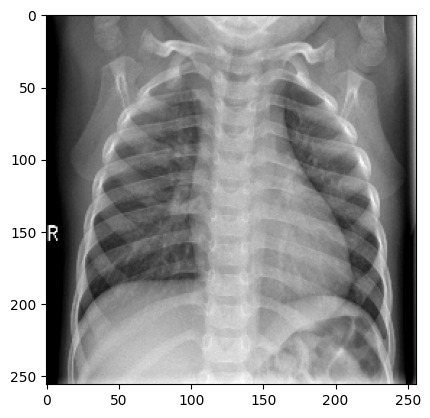

In [18]:
# Plot the first image from the dataset
plt.imshow(X_train[0], cmap=plt.cm.Greys)

----- BUILDING THE MODEL -----


In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

alpha = 1e-4
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, min_delta=alpha, patience=7, verbose=1)
early_stopping_cb = EarlyStopping(patience=7, restore_best_weights=True)

callbacks = [lr_reduce, early_stopping_cb]

In [42]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='softmax')  # Output layer for binary classification
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 516128)            0         
                                                                 
 dense_14 (Dense)            (None, 128)               66064512  
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 128)              

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
model.fit(X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data = (x_val, y_val),
    shuffle=True,
    verbose=2,

)

Epoch 1/5
165/165 - 9s - loss: 0.2831 - accuracy: 0.7413 - val_loss: 1.6657 - val_accuracy: 0.5000 - 9s/epoch - 57ms/step
Epoch 2/5
165/165 - 6s - loss: 0.1752 - accuracy: 0.7413 - val_loss: 1.0234 - val_accuracy: 0.5000 - 6s/epoch - 39ms/step
Epoch 3/5
165/165 - 6s - loss: 0.1254 - accuracy: 0.7413 - val_loss: 2.1486 - val_accuracy: 0.5000 - 6s/epoch - 39ms/step
Epoch 4/5
165/165 - 6s - loss: 0.0926 - accuracy: 0.7413 - val_loss: 0.8395 - val_accuracy: 0.5000 - 6s/epoch - 39ms/step
Epoch 5/5
165/165 - 6s - loss: 0.0738 - accuracy: 0.7413 - val_loss: 1.9781 - val_accuracy: 0.5000 - 6s/epoch - 39ms/step


In [41]:
model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


20/20 - 0s - loss: 1.1148 - accuracy: 0.6250 - 210ms/epoch - 11ms/step
Loss: 1.1148165464401245, Accuracy: 0.625


------- TEST THE MODEL ---------

In [24]:
test = np.expand_dims(X_train[0], axis=0)
plt.imshow(scaler.inverse_transform(test).reshape(28, 28), cmap=plt.cm.Greys)
model.predict(test).round()

NameError: name 'scaler' is not defined